# Applying Neural Networks to the MNIST dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

import keras as keras
from keras import layers, models
from keras.datasets import mnist
from keras.utils import to_categorical
from tensorflow.keras import backend as K
from keras.models import Model

Using TensorFlow backend.


# 1. Data

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images =test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical((test_labels))

We can view any of the handwritten digits.

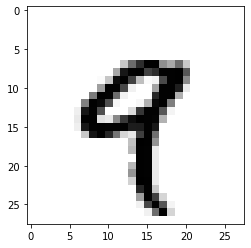

In [3]:
digit = train_images[4].reshape((28, 28))
plt.imshow(digit, cmap=plt.cm.binary)

# 2. Classification
## 2.1. Defining Network Architecture
We use a convolutional neural network to classify the images.

In [4]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# we end the network with a couple of densely connected layers
model.add(layers.Flatten())  # we first need to flatten the network
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

The last layer allows us to do 10-way classification using the softmax activation. We can look at the architecture we've defined.

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

## 2.2. Training the model

In [6]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 14s 236us/step - loss: 0.1660 - accuracy: 0.9475
Epoch 2/5
60000/60000 [==============================] - 13s 214us/step - loss: 0.0460 - accuracy: 0.9860
Epoch 3/5
60000/60000 [==============================] - 13s 215us/step - loss: 0.0321 - accuracy: 0.9902
Epoch 4/5
60000/60000 [==============================] - 13s 214us/step - loss: 0.0241 - accuracy: 0.9929
Epoch 5/5
60000/60000 [==============================] - 13s 215us/step - loss: 0.0200 - accuracy: 0.9938


We can then evaluate the model on the test data.

In [7]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

10000/10000 [==============================] - 1s 83us/step


0.9922999739646912

We see that the model achieves moe than 99% accuracy.

# 3. Generating Images with Variational Autoencoders (VAEs)
A classical autoencoder maps an input image to a latent space through an encoder module and then decodes the latent point back to an output with the same dimensions as the image via a decoder module. In practice, classical autocoders don't give useful latent spaces and they are not much good at compression.

Variational Autoenoders make the Encoder module compress the input image into parameters of a statistical distribution (e.g. Multivariate Normal). A point is sampled randomly from the distribution and the sample is used by the Decoder to reconstruct the image. The stochasticity of the process improves robustness and forces the latent space to encode meaningful representations as any two close points in the latent space will decode to very similar images. This continuity, combined with the low dimensionality of the latent space, forces every direction in the latent space to encode a meaningful axis of variation.

We shall use a convnet to encode the image into the probability distribution. As we need to sample from the latent distribution, we shall need to use Keras' functional API to define the encoding and decoding networks.

In [8]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # dimensionality of the latent space

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
# encode input image into two 2D parameters
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

We can now define the sampling function and use it to construct a layer sandwiched between the encoding and decoding parts of the network.

In [9]:
def sampling(args):
    z_mean, z_log_var = args  # log_var is a misnomer. Rather log_stddev
    # K.shape(z_mean[0]) = # in batch
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
    
z = layers.Lambda(sampling)([z_mean, z_log_var])

We now implement the decoder network. Here we reshape the sampled latent vector to the dimensions of an image and then use some convolutional layers to obtain an image output that has the same dimensions as the original `input_img`.

In [10]:
decoder_input = layers.Input(K.int_shape(z)[1:])  # the zero-th dimension in batch size
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)  #no.filters=14*14*64
x = layers.Reshape(shape_before_flattening[1:])(x)  # reshape z into feature map shaped like last conv layer
# let's now decode z into feature map with same size as original image input
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

We can now instantiate the model and apply it to z.

In [11]:
decoder = Model(decoder_input, x)
z_decoded = decoder(z)  # applies object to z to recover decoded z

The parameters of VAE are trained via two loss functions: a *reconstruction* loss that forces the decoded samples to match the initial inputs and a *regularization* loss that helps learn well-formed latent spaces and reduce overfitting to the training data.

The dual loss doesn't fit the traditional case where we calculate loss by evaluating `loss(input, target)`. We thus setup the loss by writing a built-in layer that takes into two inputs: `input_img` (the encoder's input) and `z_decoded` (the decoder's output). The built-in layer internally uses a built-in `add_loss` layer.

In [12]:
class CustomVariationalLayer (keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)  # reconstruction loss
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)  # regularization
        return K.mean(xent_loss + kl_loss)
    
    # we implement custom layers by writing a call method
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x  # we dont use this output, but call requires us to return something!

# call custom layer on input & decoded output to obtain final model output
y = CustomVariationalLayer()([input_img, z_decoded])

We can now instantiate and train the model. Since the loss is implemented via the custom layer, we don't need an external loss (i.e. `loss=None`) which in turn means we don't pass target data during training (i.e. `y=None`).

In [13]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_5[0][0]                   
____________________________________________________________________________________________

/home/d869321/anaconda3/envs/neural/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 102s 2ms/step - loss: 0.2637 - val_loss: 0.1998
Epoch 2/10
60000/60000 [==============================] - 98s 2ms/step - loss: 0.1938 - val_loss: 0.1901
Epoch 3/10
60000/60000 [==============================] - 99s 2ms/step - loss: 0.1890 - val_loss: 0.1881
Epoch 4/10
60000/60000 [==============================] - 98s 2ms/step - loss: 0.1863 - val_loss: 0.1852
Epoch 5/10
60000/60000 [==============================] - 98s 2ms/step - loss: 0.1844 - val_loss: 0.1828
Epoch 6/10
60000/60000 [==============================] - 98s 2ms/step - loss: 0.1832 - val_loss: 0.1849
Epoch 7/10
60000/60000 [==============================] - 99s 2ms/step - loss: 0.1822 - val_loss: 0.1830
Epoch 8/10
60000/60000 [==============================] - 98s 2ms/step - loss: 0.1815 - val_loss: 0.1809
Epoch 9/10
60000/60000 [==============================] - 98s 2ms/step - loss: 0.1808 - val_loss: 0.1804
Epoc

With the trained model, we can use the decoder network to turn latent space vectors into images.

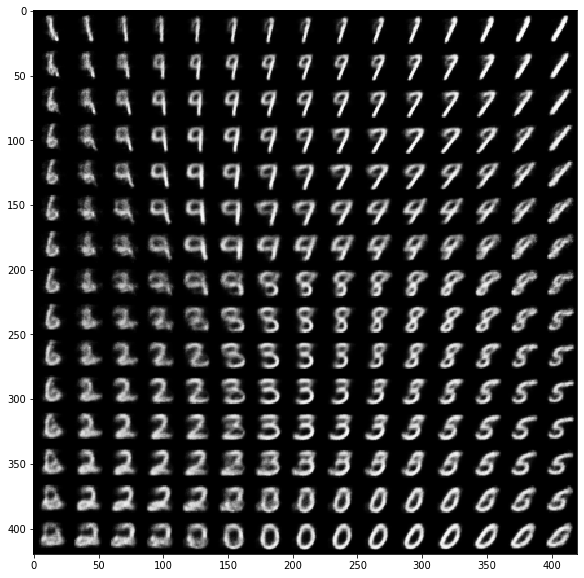

In [14]:
n = 15  # display a 15x15 grid of digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# transform linearly spaced coords with ppf fn to produce values of latent variable z
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # repeat z multiple times to form a complete batch
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)  # decodes batch into digit images
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')

We thus see how the reconstructed digits morph as we go through the space.